# Convert Image to text

In [ ]:
pip install gradio

In [ ]:
from __future__ import annotations

import os

import gradio as gr
import torch
from gradio_client import Client
from gradio_client.client import Job

DESCRIPTION = "# Comparing image captioning models"
ORIGINAL_SPACE_INFO = """\
- [GIT-large fine-tuned on COCO](https://huggingface.co/spaces/library-samples/image-captioning-with-git)
- [BLIP-large](https://huggingface.co/spaces/library-samples/image-captioning-with-blip)
- [BLIP-2 OPT 6.7B](https://huggingface.co/spaces/merve/BLIP2-with-transformers)
- [BLIP-2 T5-XXL](https://huggingface.co/spaces/hysts/BLIP2-with-transformers)
- [InstructBLIP](https://huggingface.co/spaces/library-samples/InstructBLIP)
- [Fuyu-8B](https://huggingface.co/spaces/adept/fuyu-8b-demo)
"""

torch.hub.download_url_to_file("http://images.cocodataset.org/val2017/000000039769.jpg", "cats.jpg")
torch.hub.download_url_to_file(
    "https://huggingface.co/datasets/nielsr/textcaps-sample/resolve/main/stop_sign.png", "stop_sign.png"
)
torch.hub.download_url_to_file(
    "https://cdn.openai.com/dall-e-2/demos/text2im/astronaut/horse/photo/0.jpg", "astronaut.jpg"
)


def generate_caption_git(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("hysts/image-captioning-with-git")
        fn = client.submit if return_job else client.predict
        return fn(image_path, api_name="/caption")
    except Exception:
        gr.Warning("The GIT-large Space is currently unavailable. Please try again later.")
        return ""


def generate_caption_blip(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("hysts/image-captioning-with-blip")
        fn = client.submit if return_job else client.predict
        return fn(image_path, "A picture of", api_name="/caption")
    except Exception:
        gr.Warning("The BLIP-large Space is currently unavailable. Please try again later.")
        return ""


def generate_caption_blip2_opt(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("merve/BLIP2-with-transformers")
        fn = client.submit if return_job else client.predict
        return fn(
            image_path,
            "Beam search",
            1,  # temperature
            1,  # length penalty
            1.5,  # repetition penalty
            api_name="/caption",
        )
    except Exception:
        gr.Warning("The BLIP2 OPT6.7B Space is currently unavailable. Please try again later.")
        return ""


def generate_caption_blip2_t5xxl(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("hysts/BLIP2-with-transformers")
        fn = client.submit if return_job else client.predict
        return fn(
            image_path,
            "Beam search",
            1,  # temperature
            1,  # length penalty
            1.5,  # repetition penalty
            50,  # max length
            1,  # min length
            5,  # number of beams
            0.9,  # top p
            api_name="/caption",
        )
    except Exception:
        gr.Warning("The BLIP2 T5-XXL Space is currently unavailable. Please try again later.")
        return ""


def generate_caption_instructblip(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("hysts/InstructBLIP")
        fn = client.submit if return_job else client.predict
        return fn(
            image_path,
            "Describe the image.",
            "Beam search",
            5,  # beam size
            256,  # max length
            1,  # min length
            0.9,  # top p
            1.5,  # repetition penalty
            1.0,  # length penalty
            1.0,  # temperature
            api_name="/run",
        )
    except Exception:
        gr.Warning("The InstructBLIP Space is currently unavailable. Please try again later.")
        return ""


def generate_caption_fuyu(image_path: str, return_job: bool = False) -> str | Job:
    try:
        client = Client("adept/fuyu-8b-demo")
        fn = client.submit if return_job else client.predict
        return fn(image_path, "Generate a coco style caption.\n", fn_index=3)
    except Exception:
        gr.Warning("The Fuyu-8B Space is currently unavailable. Please try again later.")
        return ""


def generate_captions(image_path: str) -> tuple[str, str, str, str, str, str]:
    jobs = [
        generate_caption_git(image_path, return_job=True),
        generate_caption_blip(image_path, return_job=True),
        generate_caption_blip2_opt(image_path, return_job=True),
        generate_caption_blip2_t5xxl(image_path, return_job=True),
        generate_caption_instructblip(image_path, return_job=True),
        generate_caption_fuyu(image_path, return_job=True),
    ]
    return tuple(job.result() if job else "" for job in jobs)


with gr.Blocks(css="style.css") as demo:
    gr.Markdown(DESCRIPTION)
    with gr.Row():
        with gr.Column():
            input_image = gr.Image(type="filepath")
            run_button = gr.Button("Caption")
        with gr.Column():
            out_git = gr.Textbox(label="GIT-large fine-tuned on COCO")
            out_blip = gr.Textbox(label="BLIP-large")
            out_blip2_opt = gr.Textbox(label="BLIP-2 OPT 6.7B")
            out_blip2_t5xxl = gr.Textbox(label="BLIP-2 T5-XXL")
            out_instructblip = gr.Textbox(label="InstructBLIP")
            out_fuyu = gr.Textbox(label="Fuyu-8B")

    outputs = [
        out_git,
        out_blip,
        out_blip2_opt,
        out_blip2_t5xxl,
        out_instructblip,
        out_fuyu,
    ]
    gr.Examples(
        examples=[
            "cats.jpg",
            "stop_sign.png",
            "astronaut.jpg",
        ],
        inputs=input_image,
        outputs=outputs,
        fn=generate_captions,
        cache_examples=os.getenv("CACHE_EXAMPLES") == "1",
    )

    with gr.Accordion(label="The original Spaces can be found here:", open=False):
        gr.Markdown(ORIGINAL_SPACE_INFO)

    run_button.click(
        fn=generate_captions,
        inputs=input_image,
        outputs=outputs,
        api_name="caption",
    )

if __name__ == "__main__":
    demo.queue(max_size=20).launch()


100%|██████████| 169k/169k [00:00<00:00, 922kB/s] 
100%|██████████| 283k/283k [00:00<00:00, 13.0MB/s]
100%|██████████| 110k/110k [00:00<00:00, 6.11MB/s]


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://7a2462f42d6f7210fb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


# Convert Text to Image

In [1]:
#diffusers is a hugging face page for using diffusion models from huggingface hub
!pip install diffusers transformers gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.4/314.4 kB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s et

In [2]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
#!pip install torch --upgrade  # Upgrade PyTorch
#!pip install diffusers --upgrade  # Upgrade Stable Diffusion Pipeline (if installed)


In [4]:
model_id1 = "dreamlike-art/dreamlike-diffusion-1.0"
model_id2 = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = StableDiffusionPipeline.from_pretrained(model_id1, torch_dtype=torch.float16, use_safetensors=True)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/901 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

# Generate Prompt using Text extracted from Images

In [5]:
import random

def generate_image_prompt(text):
  """Generates an image prompt with color, background, and additional elements.

  Args:
      text: The text description of the object (obtained from text detection).

  Returns:
      A string containing the image prompt.
  """

  # Define base prompt and color options
  base_prompt = "A photorealistic image of {}."
  colors = ["pastel", "vibrant", "muted", "monochromatic"]

  # Analyze text to tailor prompt elements
  if "shaving soap" in text:
    keywords = ["tin", "shaving", "soap", "orange", "label"]
    variations = {
        "tin": ["canister", "container"],
        "shaving": ["barber", "grooming"],
        "soap": ["lather", "bar"],
        "orange": ["citrus", "tangerine", "apricot"],
        "label": ["tag", "wrapper"]
    }
    background = "a rustic wooden shelf with a vintage shaving mug and brush"
    elements = []
  elif "ring" in text:  # Handle rings, checking for engagement
    is_engagement_ring = "engagement" in text.lower()
    keywords = ["ring", "gold", "diamond", "silver", "gemstone"]
    variations = {
        "ring": ["band", "jewelry"],
        "gold": ["yellow gold", "rose gold", "white gold"],
        "diamond": ["gemstone", "brilliant"],
        "silver": ["sterling silver", "platinum"],
        "gemstone": ["sapphire", "emerald", "ruby", "pearl"]
    }
    if is_engagement_ring:
      background = "a velvet box with a red satin lining"
      elements = ["a single rose petal resting on the box"]
    else:  # Not an engagement ring
      background = "a close-up view on a patterned fabric"
      elements = ["a stack of other colorful rings, some made of different materials"]
  elif "shampoo" in text:  # Update for facewash
    keywords = ["facewash", "bottle", "white", "blue", "gel"]  # Change keywords for facewash
    variations = {
        "shampoo": ["cleanser", "facewash"],  # Update variations for facewash
        "bottle": ["flacon", "vial", "dispenser"],
        "white": ["pearl", "ivory", "eggshell"],
        "blue": ["aqua", "azure", "sapphire"],
        "liquid": ["gel", "lotion", "cream"]  # Update "liquid" to "gel" for facewash
    }
    background = "a marble bathroom vanity with a washcloth and towel"
    elements = ["a small potted succulent plant beside the bottle"]
  elif "shoes" in text:
    keywords = ["shoes", "loafers", "leather", "brown", "men's", "formal", "casual"]
    variations = {
        "shoes": ["footwear", "calzado"],
        "loafers": ["slip-ons"],
        "leather": ["suede", "calfskin", "patent"],
        "brown": ["tan", "cognac", "chestnut"],
        "men's": ["gentleman's", "masculine"],
        "formal": ["dressy", "polished", "sophisticated"],
        "casual": ["everyday", "relaxed", "unstructured"]
    }
    background = "a wooden floor in a cozy home library"
    elements = ["a pair of socks peeking out from one of the shoes"]
  elif "camera" in text:
    keywords = ["camera", "film", "black", "silver", "old-fashioned"]
    variations = {
        "camera": ["lens", "viewfinder", "shutter"],
        "film": ["analog", "celluloid", "vintage"],
        "black": ["charcoal", "ebony", "jet"],
        "silver": ["chrome", "pewter", "metallic"],
        "old-fashioned": ["retro", "antique", "vintage"]
    }
    background = "a wooden table with a vintage globe and a leather-bound travel journal"
    elements = ["a worn leather camera strap hanging from the camera"]
  else:
    keywords = []  # No specific keywords for generic objects
    variations = {}
    background = "a neutral background"
    elements = []
  # Replace keywords with variations
  for keyword, options in variations.items():
    if keyword in text:
      replacement = random.choice(options)
      text = text.replace(keyword, replacement)

  # Combine elements
  prompt = base_prompt.format(text) + f"\nThe background is {background} with {random.choice(colors)} colors."
  prompt += f"\n{', '.join(elements)}"

  return prompt

# Example usage
text1 = "a round tin of shaving soap with an orange label"
text2 = "An elegant gold and diamond engagement ring featuring a gray diamond in the center, surrounded by smaller diamonds on the band. The ring showcases a unique and eye-catching design, making it a standout piece for any special occasion."
text3 = "A bottle of perfume is displayed on a white background. The bottle has a black cap and is filled with an amber-colored liquid. The bottle is positioned in the center of the image, making it the focal point of the scene."
text4 = "This is a pair of men's brown leather loafers, featuring a classic penny loafer design. The shoes are made from premium leather and have a comfortable fit, making them perfect for both casual and formal occasions. They are available in various sizes to accommodate different foot sizes. The shoes are placed on a white background, showcasing their sleek and stylish appearance."
text5 = "In the image, there is a black and silver camera sitting on a white background. The camera is positioned in the center of the image, with its lens facing towards the viewer. It appears to be an old-fashioned film camera, possibly from the 1960s or 1970s."

  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A photorealistic image of a round canister of barber lather with an tangerine tag.
The background is a rustic wooden shelf with a vintage shaving mug and brush with pastel colors.



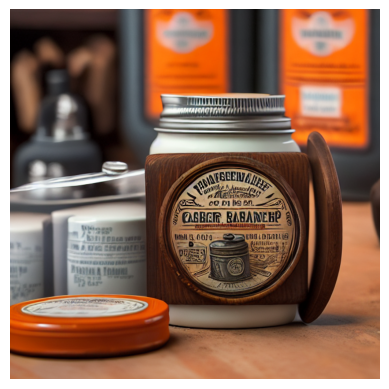

In [6]:
prompt1 = generate_image_prompt(text1)#Shaving Face wash
image1 = pipe(prompt1).images[0]
print("[PROMPT]: ",prompt1)
plt.imshow(image1);
plt.axis('off');

Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A photorealistic image of An elegant yellow gold and brilliant engagement band featuband a gray brilliant in the center, surrounded by smaller brilliants on the band. The band showcases a unique and eye-catching design, making it a standout piece for any special occasion..
The background is a velvet box with a red satin lining with vibrant colors.
a single rose petal resting on the box


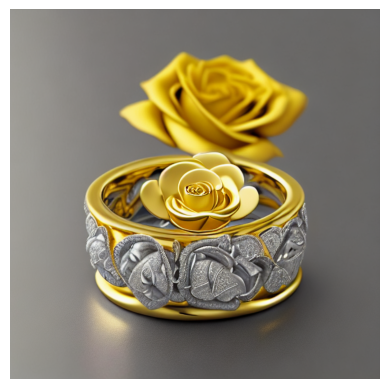

In [7]:
prompt2 = generate_image_prompt(text2)##Ring
image2 = pipe(prompt2).images[0]
print("[PROMPT]: ",prompt2)
plt.imshow(image2);
plt.axis('off');

  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A photorealistic image of A bottle of perfume is displayed on a white background. The bottle has a black cap and is filled with an amber-colored liquid. The bottle is positioned in the center of the image, making it the focal point of the scene..
The background is a neutral background with monochromatic colors.



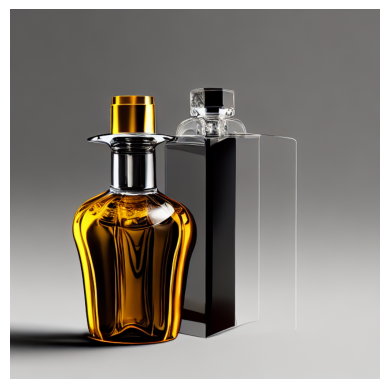

In [8]:
prompt3 = generate_image_prompt(text3)###shampoo
image3 = pipe(prompt3).images[0]
print("[PROMPT]: ",prompt3)
plt.imshow(image3);
plt.axis('off');

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with pastel colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A photorealistic image of This is a pair of men's brown leather loafers, featuband a classic penny loafer design. The shoes are made from premium leather and have a comfortable fit, making them perfect for both casual and formal occasions. They are available in various sizes to accommodate different foot sizes. The shoes are placed on a white background, showcasing their sleek and stylish appearance..
The background is a close-up view on a patterned fabric with pastel colors.
a stack of other colorful rings, some made of different materials


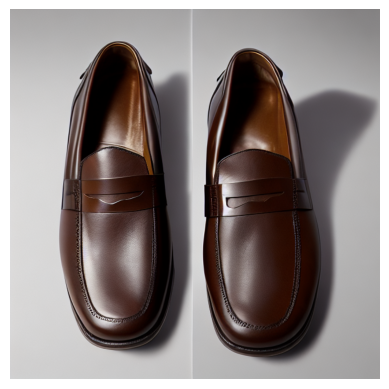

In [9]:
prompt4 = generate_image_prompt(text4)###shoe
image4 = pipe(prompt4).images[0]
print("[PROMPT]: ",prompt4)
plt.imshow(image4);
plt.axis('off');

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['with a vintage globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

[PROMPT]:  A photorealistic image of In the image, there is a jet and metallic viewfinder sitting on a white background. The viewfinder is positioned in the center of the image, with its lens facing towards the viewer. It appears to be an antique celluloid viewfinder, possibly from the 1960s or 1970s..
The background is a wooden table with a vintage globe and a leather-bound travel journal with vibrant colors.
a worn leather camera strap hanging from the camera


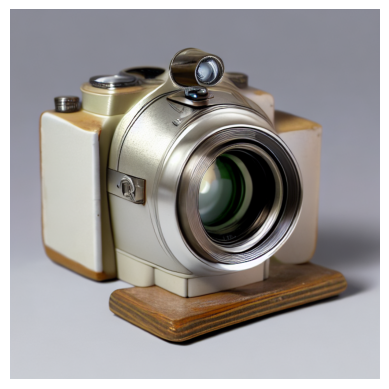

In [10]:
prompt5 = generate_image_prompt(text5)###camera
image5 = pipe(prompt5).images[0]
print("[PROMPT]: ",prompt5)
plt.imshow(image5);
plt.axis('off');

In [ ]:
import matplotlib.pyplot as plt

# Assuming prompt3 is defined (replace with your actual logic)
prompt3 = generate_image_prompt(text3)

# Generate multiple images
images = [pipe(prompt3)["images"][0] for _ in range(5)]  # Use pipe to generate images

# Display the images in a grid
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # Adjust figsize for better visualization

for i, image in enumerate(images):
  axes[i].imshow(image)
  axes[i].set_title(f"Image {i+1}")
  axes[i].axis('off')  # Hide axes for cleaner presentation

# Display the complete figure
plt.tight_layout()
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

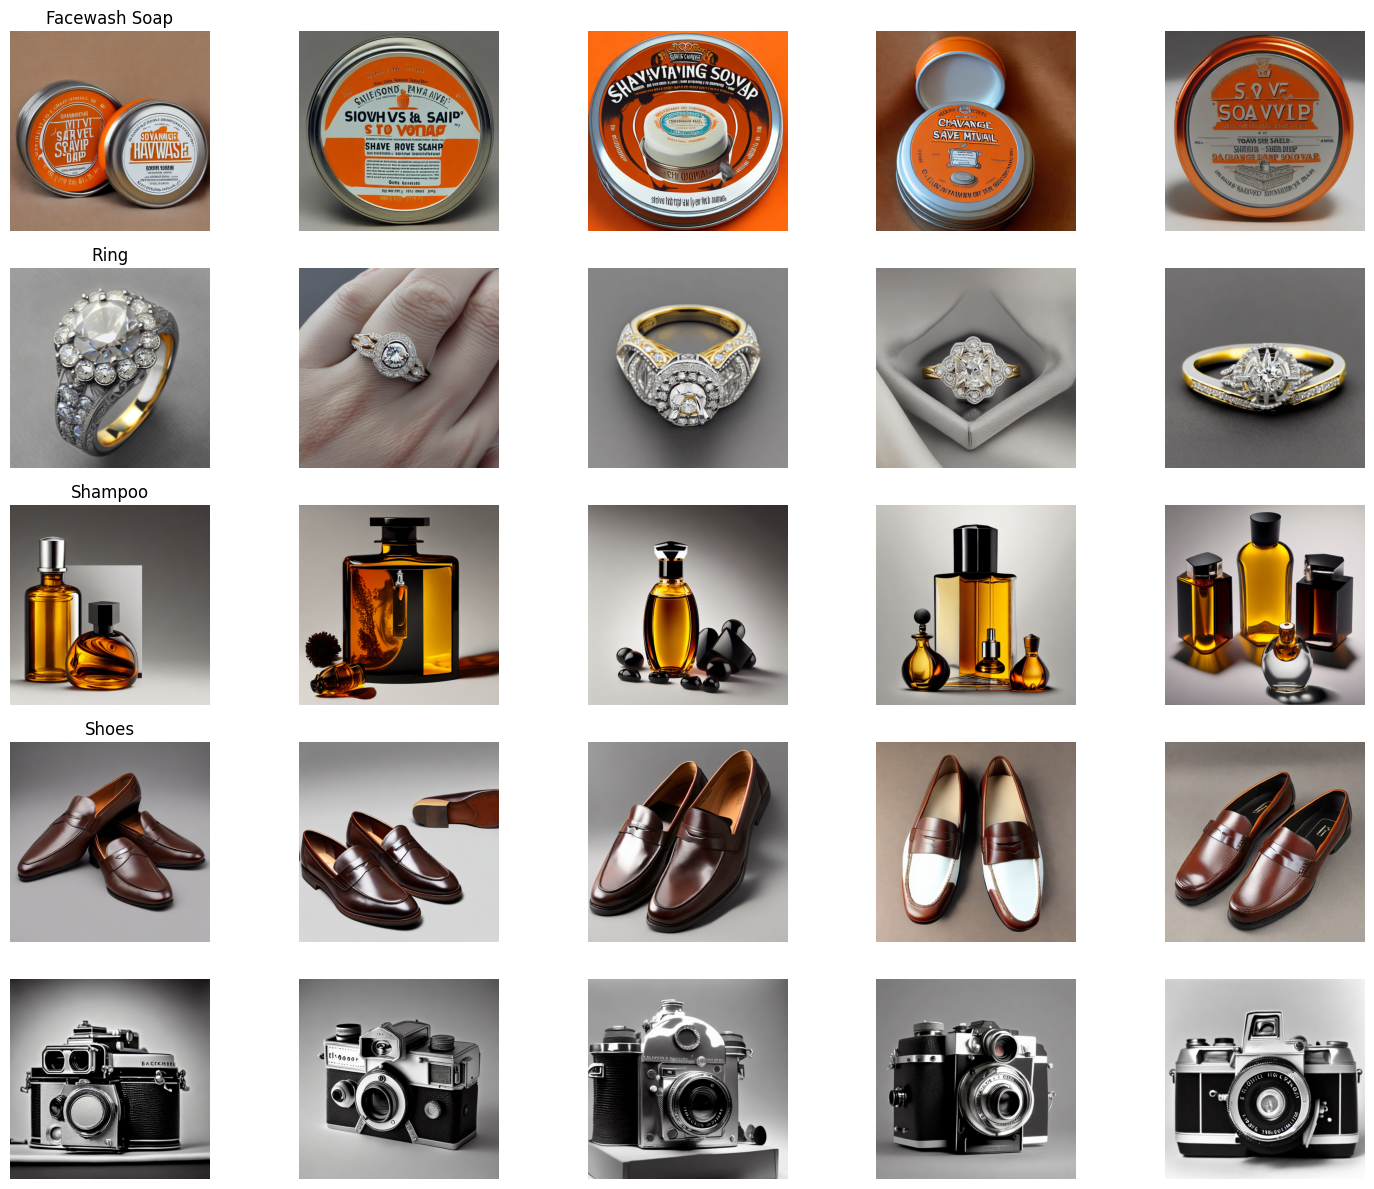

In [17]:
import matplotlib.pyplot as plt
import math

def generate_text_images_and_display(text_prompts, headings, num_images_per_prompt=5, figsize=(15, 12)):
    """Generates images for multiple prompts and displays them in a grid layout.

    Args:
        text_prompts (list): List of text prompts for image generation.
        headings (list): List of headings for each row.
        num_images_per_prompt (int, optional): Number of images to generate for each prompt. Defaults to 5.
        figsize (tuple, optional): Size of the figure in inches. Defaults to (15, 12).
    """

    total_images = len(text_prompts) * num_images_per_prompt
    num_rows = int(math.ceil(total_images / 5))  # Calculate number of rows based on total images and 5 columns

    fig, axes = plt.subplots(num_rows, 5, figsize=figsize)  # Create grid layout for all images
    axes = axes.ravel()  # Flatten axes for efficient iteration

    current_row = 0
    current_image = 0
    for i, prompt in enumerate(text_prompts):
        # Generate images for the current prompt
        images = [pipe(prompt)["images"][0] for _ in range(num_images_per_prompt)]

        # Display all generated images, up to num_images_per_prompt
        for j, image in enumerate(images):
            try:
                axes[current_image].imshow(image)
                axes[current_image].axis('off')  # Hide axes
            except IndexError:
                print(f"Warning: Index error encountered for prompt {i + 1}. Skipping images.")
            current_image += 1

        # Check if all prompts have been displayed or if the last row has been reached
        if current_row >= len(headings) or current_image >= len(axes):
            break

        # Set title for the row (avoid out-of-bounds access)
        axes[current_image - 5].set_title(headings[current_row])  # Adjusted index to ensure valid access
        current_row += 1

    plt.tight_layout()
    plt.show()

# Example usage with potential short prompt and adjusted headings:
text_prompts = [text1, text2, text3, text4, text5]  # Assuming text5 might generate fewer images
headings = ['Facewash Soap', 'Ring', 'Shampoo', 'Shoes']  # Adjusted headings
text_prompts = [text1, text2, text3, text4, text5]  # Assuming text5 might generate fewer images
headings = ['Facewash Soap', 'Ring', 'Shampoo', 'Shoes']
generate_text_images_and_display(text_prompts, headings)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the box']


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with monochromatic colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with monochromatic colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with monochromatic colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with monochromatic colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['stylish appearance.. the background is a close - up view on a patterned fabric with monochromatic colors. a stack of other colorful rings, some made of different materials']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['globe and a leather - bound travel journal with vibrant colors. a worn leather camera strap hanging from the camera']


  0%|          | 0/50 [00:00<?, ?it/s]

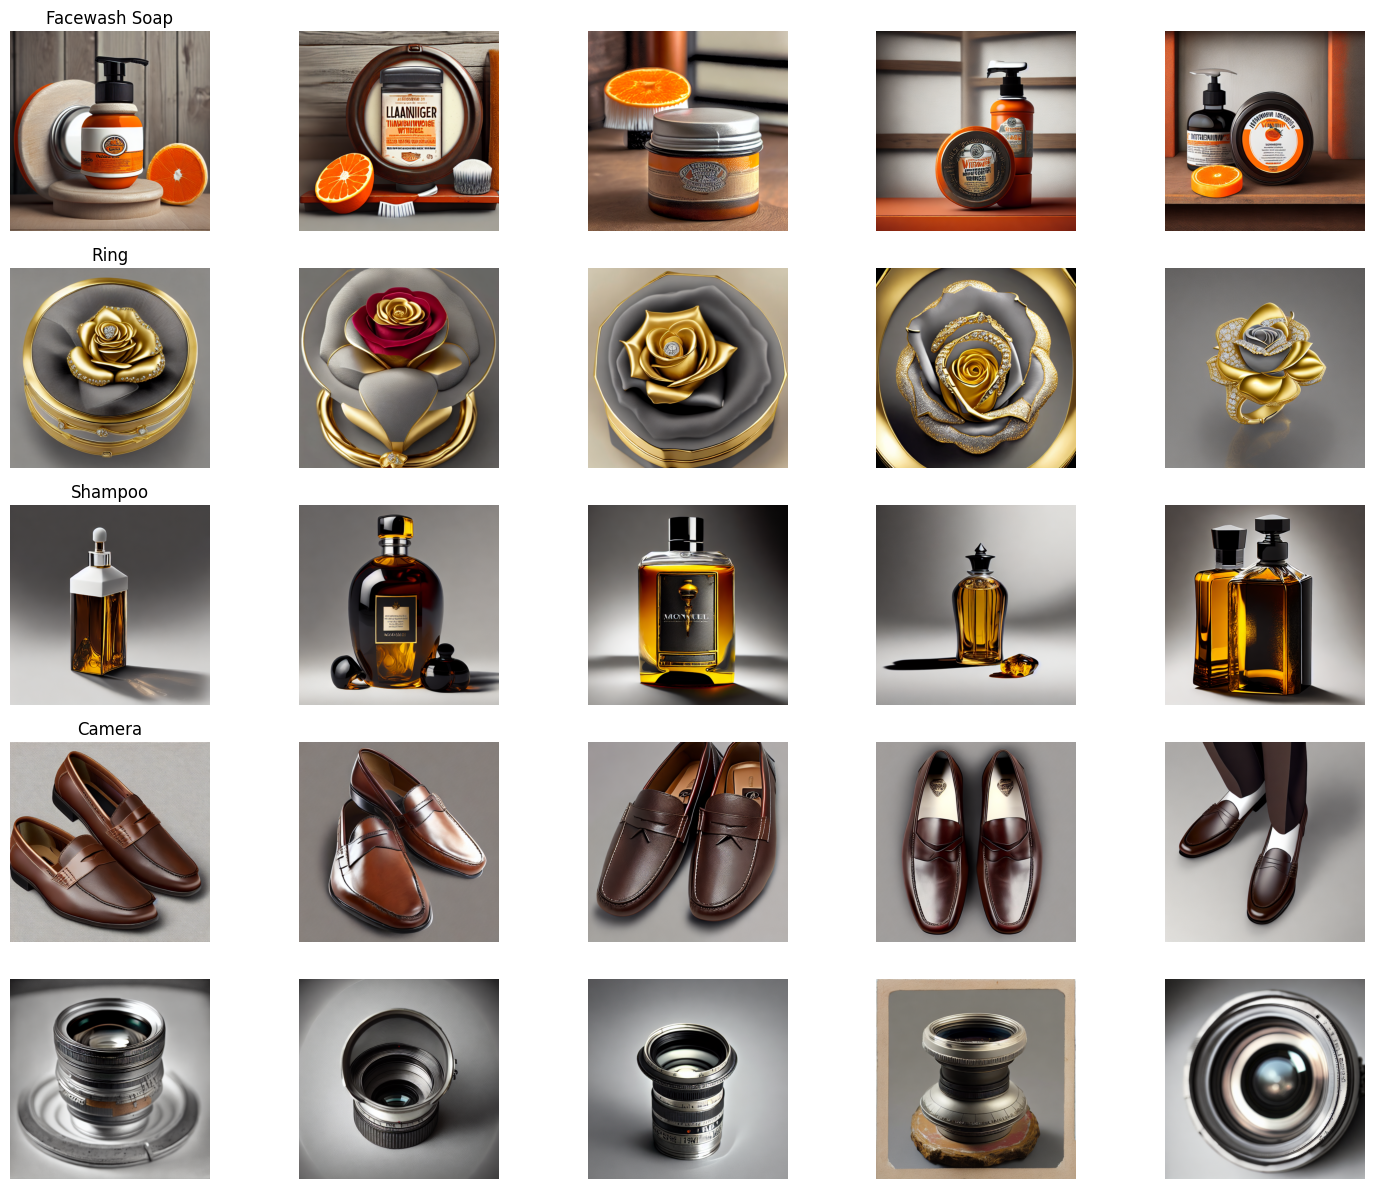

In [18]:
import matplotlib.pyplot as plt
import math

def generate_images_and_display(prompts, headings, num_images_per_prompt=5, figsize=(15, 12)):
    """Generates images for multiple prompts and displays them in a grid layout.

    Args:
        text_prompts (list): List of text prompts for image generation.
        headings (list): List of headings for each row.
        num_images_per_prompt (int, optional): Number of images to generate for each prompt. Defaults to 5.
        figsize (tuple, optional): Size of the figure in inches. Defaults to (15, 12).
    """

    total_images = len(prompts) * num_images_per_prompt
    num_rows = int(math.ceil(total_images / 5))  # Calculate number of rows based on total images and 5 columns

    fig, axes = plt.subplots(num_rows, 5, figsize=figsize)  # Create grid layout for all images
    axes = axes.ravel()  # Flatten axes for efficient iteration

    current_row = 0
    current_image = 0
    for i, prompt in enumerate(prompts):
        # Generate images for the current prompt
        images = [pipe(prompt)["images"][0] for _ in range(num_images_per_prompt)]

        # Display all generated images, up to num_images_per_prompt
        for j, image in enumerate(images):
            try:
                axes[current_image].imshow(image)
                axes[current_image].axis('off')  # Hide axes
            except IndexError:
                print(f"Warning: Index error encountered for prompt {i + 1}. Skipping images.")
            current_image += 1

        # Check if all prompts have been displayed or if the last row has been reached
        if current_row >= len(headings) or current_image >= len(axes):
            break

        # Set title for the row (avoid out-of-bounds access)
        axes[current_image - 5].set_title(headings[current_row])  # Adjusted index to ensure valid access
        current_row += 1

    plt.tight_layout()
    plt.show()

# Example usage with potential short prompt and adjusted headings:
prompts = [generate_image_prompt(text1), generate_image_prompt(text2),
           generate_image_prompt(text3), generate_image_prompt(text4),
           generate_image_prompt(text5)]
headings = ['Facewash Soap', 'Ring', 'Shampoo', 'Camera']
generate_images_and_display(prompts, headings)
